# 2024
---

In [1]:
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import warnings
import calplot
from itables import init_notebook_mode, show
import itables.options as opt

opt.dom = "tpir"
opt.style = "table-layout:auto;width:auto"
init_notebook_mode(all_interactive=True, connected=True)

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [2]:
row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            cve = entry['cve']['id']
            try:
                assigner = entry['cve']['sourceIdentifier']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['cve']['published']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                attack_vector = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data'
            try:
                attack_complexity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data'
            try:
                privileges_required = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data'
            try:
                user_interaction = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data'
            try:
                scope = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['scope']
            except KeyError:
                scope = 'Missing_Data'
            try:
                confidentiality_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data'
            try:
                integrity_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data'
            try:
                availability_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data'
            try:
                base_score = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data'
            try:
                exploitability_score = entry['cve']['metrics']['cvssMetricV31'][0]['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data'
            try:
                impact_score = entry['cve']['metrics']['cvssMetricV31'][0]['impactScore']
            except KeyError:
                impact_score = 'Missing_Data'
            try:
                cwe = entry['cve']['weaknesses'][0]['description'][0]['value']
            except KeyError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['descriptions'][0]['value']
            except IndexError:
                description = ''
            new_row = {
                'CVE': cve,
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner
            }
            if not description.startswith('rejected reason'): 
                row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
    
nvd['Published'] = pd.to_datetime(nvd['Published'])
thisyear = ((nvd['Published'] > '2024-01-01') & (nvd['Published']  < '2025-01-01'))
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2024, 1, 1)
enddate  = date.today()
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

In [3]:
Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day.round(2)}**<br />Average CVSS Score: **{nvd['BaseScore'].mean().round(2)}**")

Total Number of CVEs: **23476**<br />Average CVEs Per Day: **112.87**<br />Average CVSS Score: **6.72**



## CVE Graphs

In [4]:
Month_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("M")).agg('count')
Year_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("Y")).agg('count')
Week_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("W")).agg('count')
Day_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("D")).agg('count')

### CVE Calendar

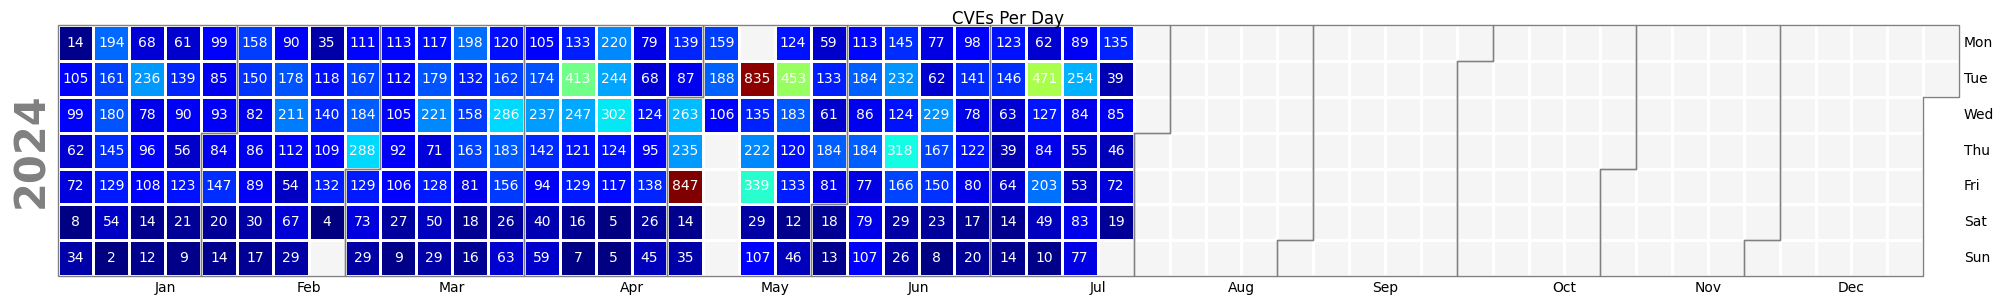

In [5]:
dfs = nvd['Published'].apply(lambda x: pd.to_datetime(x, errors='coerce', format='%Y/%m/%d'))
df = dfs.value_counts()
df = df.to_frame()
df.index = df.index.strftime('%m/%d/%Y')
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')
calplot.calplot(df.T.squeeze(), cmap='jet', dropzero=True, edgecolor="Grey", textcolor="White", textformat='{:.0f}', textfiller='', suptitle='CVEs Per Day', figsize=(25,3));

### CVE Per Month Graph

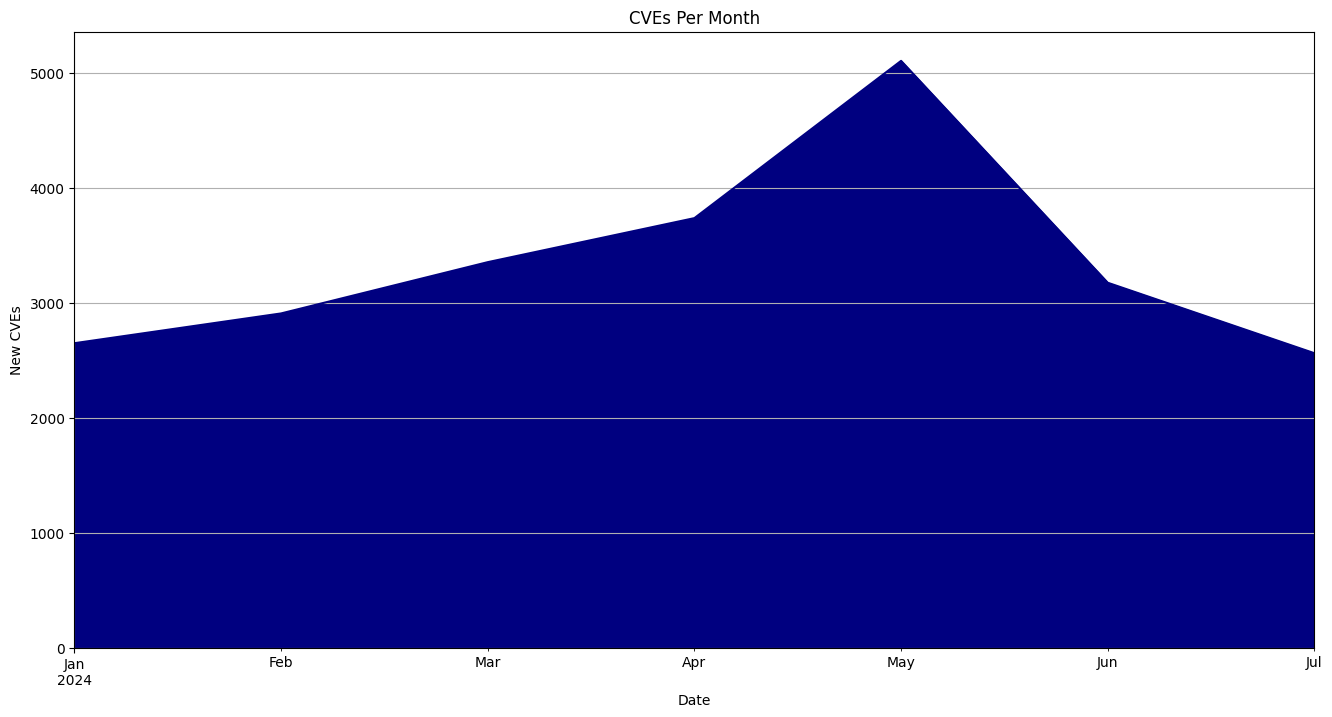

In [6]:
cg = Month_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Month')
plt.grid()
cg.set_ylabel("New CVEs");
cg.set_xlabel("Date");



### CVE Per Week Graph

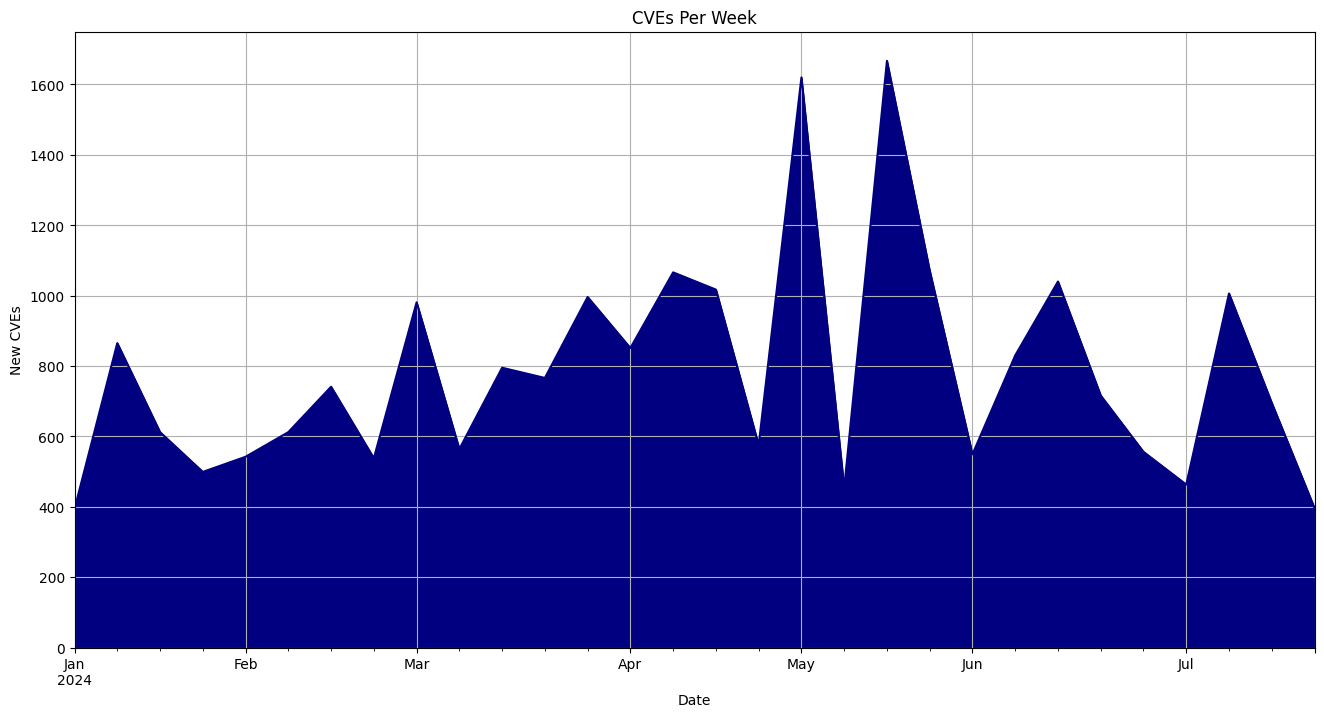

In [7]:
cg = Week_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Week')
plt.grid()
cg.set_ylabel("New CVEs");
cg.set_xlabel("Date");



### CVE Per Day Graph

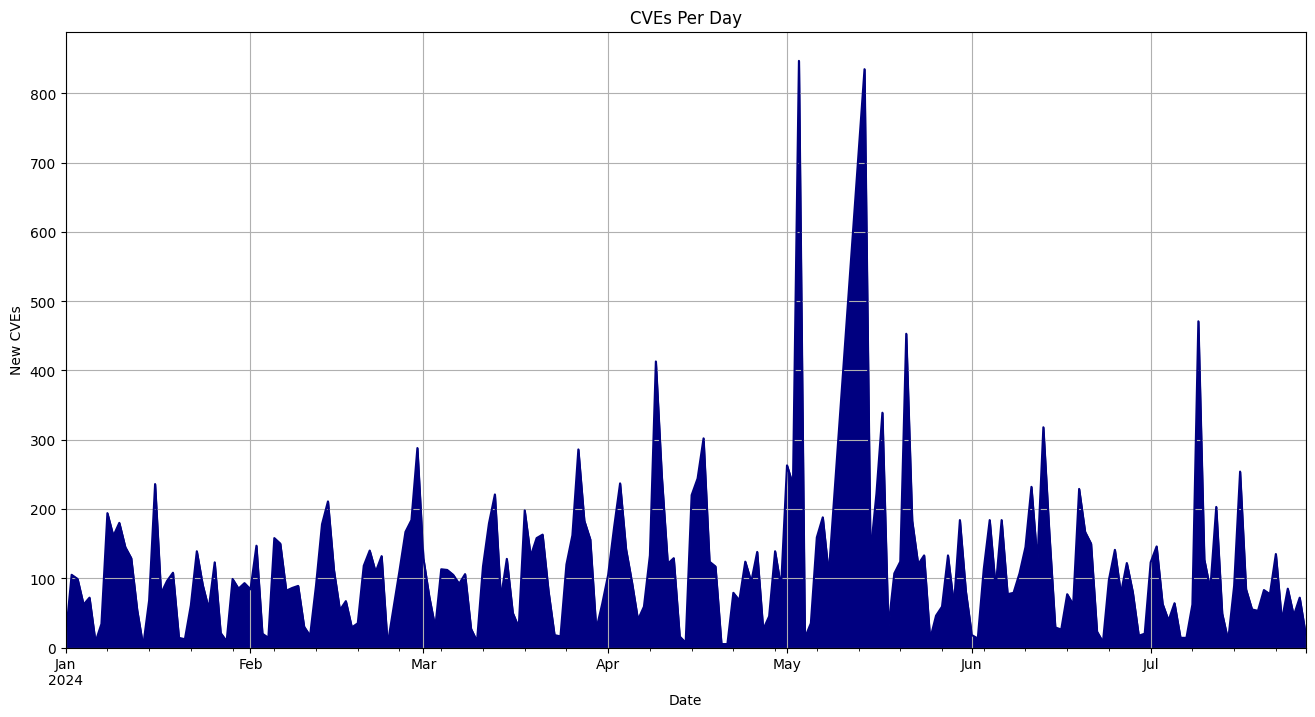

In [8]:
cg = Day_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Day')
plt.grid()
cg.set_ylabel("New CVEs");
cg.set_xlabel("Date");


## CVSS Data

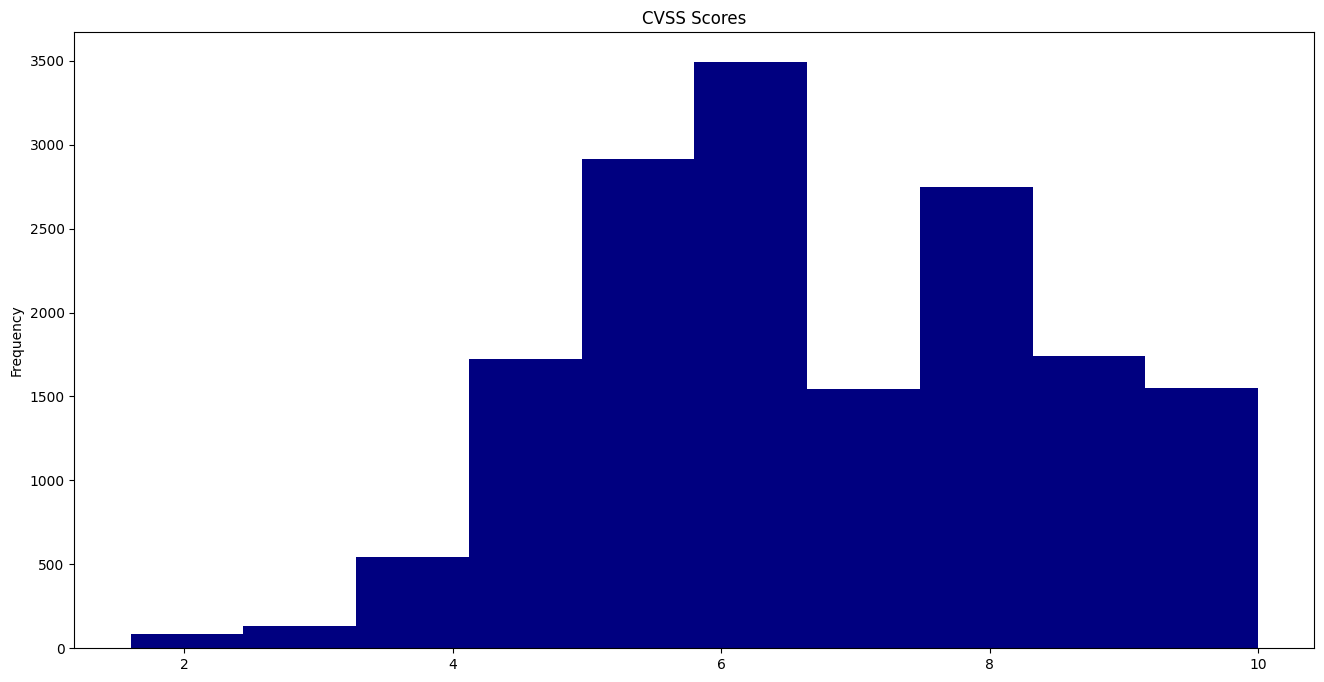

In [9]:
nvd['BaseScore'].plot(kind="hist", colormap='jet', figsize=(16, 8), title='CVSS Scores');

## CNA Data

### CNA Assigner Graph

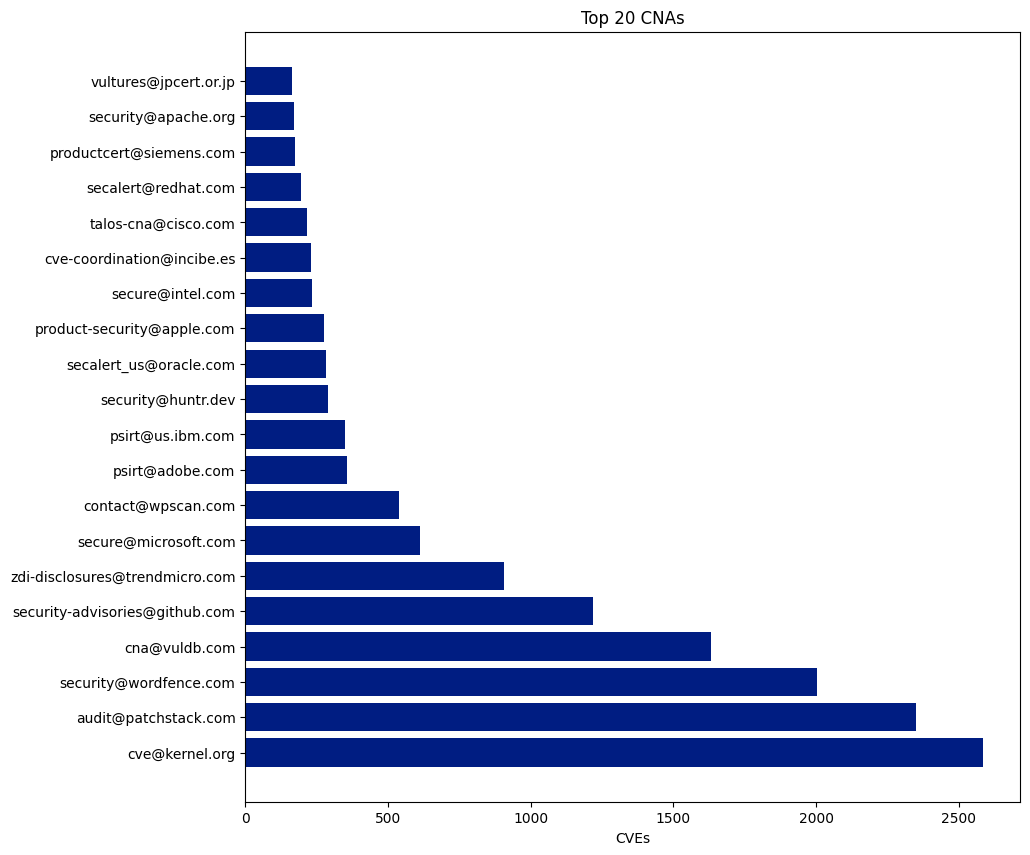

In [10]:
nvd['Assigner'].replace('416baaa9-dc9f-4396-8d5f-8c081fb06d67','cve@kernel.org',inplace=True)
nvd_frequency = nvd['Assigner'].value_counts()
nvd_frequency = nvd_frequency.reset_index()
nvd_frequency.columns = ['Assigner', 'CVEs']
nvd_frequency['Percentage'] = round((nvd_frequency['CVEs'] / 
                       nvd_frequency['CVEs'].sum()) * 100)
nvd_frequency[nvd_frequency.CVEs > 100].head(50)
nvd_frequency_no_mitre = nvd_frequency[~nvd_frequency.Assigner.str.contains('cve@mitre.org')]
nvd_frequency_no_mitre = nvd_frequency_no_mitre[nvd_frequency_no_mitre.CVEs > 1].head(20)
plt.figure(figsize=(10,10))
plt.barh("Assigner", "CVEs", data = nvd_frequency_no_mitre, color="#001d82")
plt.xlabel("CVEs"); 
plt.ylabel("") ;
plt.title("Top 20 CNAs");




## CWE Data

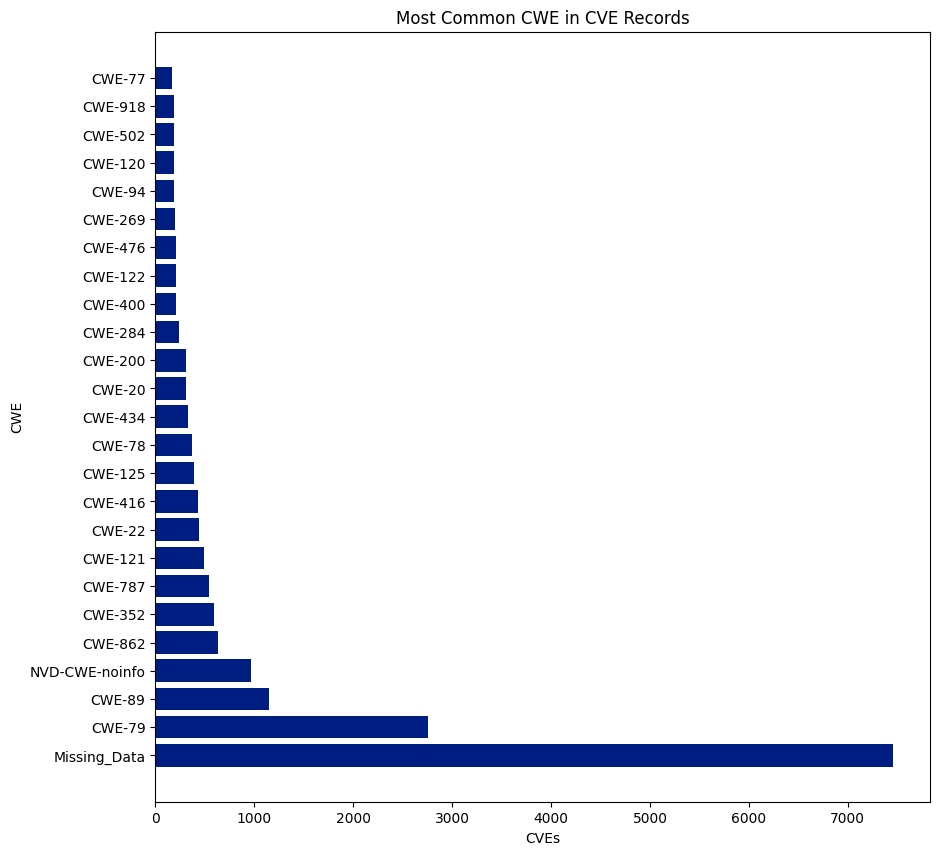

In [11]:
nvd_cwe = nvd['CWE'].value_counts()
nvd_cwe = nvd_cwe.reset_index()
nvd_cwe.columns = ['CWE', 'CVEs']
nvd_cwe_graph = nvd_cwe[nvd_cwe.CVEs > 10].head(25)
plt.figure(figsize=(10,10));
plt.barh("CWE", "CVEs", data = nvd_cwe_graph, color="#001d82");
plt.xlabel("CVEs"); 
plt.ylabel("CWE") ;
plt.title("Most Common CWE in CVE Records");




## More CVE Data




### Top CNA Assigners

In [12]:
show(nvd_frequency, scrollY="400px", scrollCollapse=True, paging=False)

### Top CWEs

In [13]:
show(nvd_cwe, scrollY="400px", scrollCollapse=True, paging=False)




### CVEs By Identifier

In [14]:
print("CVE-1999:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-1999-')]))
print("CVE-2000:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2000-')]))
print("CVE-2001:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2001-')]))
print("CVE-2002:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2002-')]))
print("CVE-2003:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2003-')]))
print("CVE-2004:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2004-')]))
print("CVE-2005:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2005-')]))
print("CVE-2006:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2006-')]))
print("CVE-2007:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2007-')]))
print("CVE-2008:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2008-')]))
print("CVE-2009:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2009-')]))
print("CVE-2010:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2010-')]))
print("CVE-2011:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2011-')]))
print("CVE-2012:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2012-')]))
print("CVE-2013:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2013-')]))
print("CVE-2014:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2014-')]))
print("CVE-2015:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2015-')]))
print("CVE-2016:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2016-')]))
print("CVE-2017:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2017-')]))
print("CVE-2018:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2018-')]))
print("CVE-2019:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2019-')]))
print("CVE-2020:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2020-')]))
print("CVE-2021:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2021-')]))
print("CVE-2022:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2022-')]))
print("CVE-2023:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2023-')]))
print("CVE-2024:\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2024-')]))

CVE-1999:	0
CVE-2000:	0
CVE-2001:	0
CVE-2002:	0
CVE-2003:	0
CVE-2004:	0
CVE-2005:	0
CVE-2006:	0
CVE-2007:	0
CVE-2008:	0
CVE-2009:	0
CVE-2010:	1
CVE-2011:	2
CVE-2012:	1
CVE-2013:	0
CVE-2014:	3
CVE-2015:	6
CVE-2016:	5
CVE-2017:	4
CVE-2018:	8
CVE-2019:	19
CVE-2020:	70
CVE-2021:	881
CVE-2022:	495
CVE-2023:	4744
CVE-2024:	17237


In [15]:
Markdown(f"This report is updated automatically every day, last generated on: **{datetime.datetime.now()}**")

This report is updated automatically every day, last generated on: **2024-07-27 16:09:57.164334**